<a href="https://colab.research.google.com/github/samiraabnar/attention_flow/blob/master/bert_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# %pip install transformers

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [4]:
# %ls

In [5]:
# !git clone https://github.com/samiraabnar/attention_flow

In [6]:
# %cd gdrive/My Drive/attention_flow/

In [7]:
%pip install tensorflow_datasets

Note: you may need to restart the kernel to use updated packages.


In [8]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from attention_graph_util import *
import seaborn as sns
import itertools 
import matplotlib as mpl

rc={'font.size': 10, 'axes.labelsize': 10, 'legend.fontsize': 10.0, 
    'axes.titlesize': 32, 'xtick.labelsize': 20, 'ytick.labelsize': 16}
plt.rcParams.update(**rc)
mpl.rcParams['axes.linewidth'] = .5 #set the value globally

import torch
from transformers import AutoModelForSequenceClassification
from transformers import AutoModelForMaskedLM
from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

def plot_attention_heatmap(att, s_position, t_positions, sentenceax):
    print(att.shape)
    # att = B, L, L
    #   print(att[:,s_position].shape, att[:,s_position])
    #   print(att.shape, att[:,s_position, t_positions])
    # pega todas as matrizes de atenção nas linhas s e colunas t, geralmente s é escalar
    # flipa no eixo do indice da matriz. Antes era (0, ..., L-1) agora (L-1, ..., 0)
    cls_att = np.flip(att[:,s_position, t_positions], axis=0)

    # cls_att = np.flip(att[:,s_position, 1:-1], axis=0)
    #   print(cls_att)
    # x é somente o t
    xticklb = input_tokens= list(itertools.compress(sentenceax, [i in t_positions for i in np.arange(len(sentence)+1)]))
    yticklb = [str(i) if i%2 ==0 else '' for i in np.arange(att.shape[0],0, -1)]
    # xticklb = list(itertools.compress(['<cls>']+sentence.split()+['<sep>'], [True for i in np.arange(len(sentence)+1)]))
    # print(xticklb)
    # print(sentence)


    yticklb = [str(i) if i%2 ==0 else '' for i in np.arange(att.shape[0],0, -1)]
    ax = sns.heatmap(cls_att, xticklabels=xticklb, yticklabels=yticklb, cmap="YlOrRd")
    return ax


def convert_adjmat_tomats(adjmat, n_layers, l):
   mats = np.zeros((n_layers,l,l))
   
   for i in np.arange(n_layers):
       mats[i] = adjmat[(i+1)*l:(i+2)*l,i*l:(i+1)*l]
       
   return mats

def draw_attention_graph(adjmat, labels_to_index, n_layers, length):
    A = adjmat
    G=nx.from_numpy_array(A, create_using=nx.DiGraph())
    for i in np.arange(A.shape[0]):
        for j in np.arange(A.shape[1]):
            nx.set_edge_attributes(G, {(i,j): A[i,j]}, 'capacity')

    pos = {}
    label_pos = {}
    for i in np.arange(n_layers+1):
        for k_f in np.arange(length):
            pos[i*length+k_f] = ((i+0.4)*2, length - k_f)
            label_pos[i*length+k_f] = (i*2, length - k_f)

    index_to_labels = {}
    for key in labels_to_index:
        index_to_labels[labels_to_index[key]] = key.split("_")[-1]
        if labels_to_index[key] >= length:
            index_to_labels[labels_to_index[key]] = ''

    #plt.figure(1,figsize=(20,12))

    nx.draw_networkx_nodes(G,pos,node_color='green', label=index_to_labels, node_size=50)
    nx.draw_networkx_labels(G,pos=label_pos, labels=index_to_labels, font_size=18)

    all_weights = []
    #4 a. Iterate through the graph nodes to gather all the weights
    for (node1,node2,data) in G.edges(data=True):
        all_weights.append(data['weight']) #we'll use this when determining edge thickness

    #4 b. Get unique weights
    unique_weights = list(set(all_weights))

    #4 c. Plot the edges - one by one!
    for weight in unique_weights:
        #4 d. Form a filtered list with just the weight you want to draw
        weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in G.edges(data=True) if edge_attr['weight']==weight]
        #4 e. I think multiplying by [num_nodes/sum(all_weights)] makes the graphs edges look cleaner
        
        w = weight #(weight - min(all_weights))/(max(all_weights) - min(all_weights))
        width = w
        nx.draw_networkx_edges(G,pos,edgelist=weighted_edges,width=width, edge_color='darkblue')
    
    return G
 
def get_adjmat(mat, input_tokens):
    n_layers, length, _ = mat.shape
    adj_mat = np.zeros(((n_layers+1)*length, (n_layers+1)*length))
    print(adj_mat.shape, n_layers, length)
    labels_to_index = {}
    for k in np.arange(length):
        labels_to_index[str(k)+"_"+input_tokens[k]] = k

    #cada camada
    for i in np.arange(1,n_layers+1):
        #cada nó em camada
        for k_f in np.arange(length):
            index_from = (i)*length+k_f
            label = "L"+str(i)+"_"+str(k_f)
            labels_to_index[label] = index_from
            for k_t in np.arange(length):
                # cada nó em camada seguinte
                index_to = (i-1)*length+k_t
                # adj[i,j] é o valor da atenção 
                adj_mat[index_from][index_to] = mat[i-1][k_f][k_t]
    # print(adj_mat[length:2*length,0:length], i, k_f, k_t)
    return adj_mat, labels_to_index 



c:\Users\augus\anaconda3\envs\inspecting_gpt\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
pretrained_weights = 'gpt2'
model = AutoModelForCausalLM.from_pretrained(pretrained_weights,
                                             output_hidden_states=True,
                                             output_attentions=True)
model.zero_grad()
tokenizer = AutoTokenizer.from_pretrained(pretrained_weights, use_fast=True)


The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Loading weights: 100%|██████████| 148/148 [00:00<00:00, 274.17it/s, Materializing param=transformer.wte.weight]             
GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [10]:
sentences = {}
src = {}
targets = {}

sentences[0] = "He talked to her about his book"
src[0] = 6 # onde esta o mask/proxima palavra
targets[0] = (1,4) # depois que adiciona o cls viram os agentes

sentences[1] = "She asked the doctor about "+" backache"
src[1] = 6
targets[1] = (1,4) 

sentences[2] = "The author talked to Sara about his"
src[2] = 7
targets[2] = (2,5) 

sentences[3] = "John tried to convince Mary of his love and brought flowers for "
src[3] = 13
targets[3] = (1,5) 

sentences[4] = "Mary convinced John of "+" love"
src[4] = 5
targets[4] = (1,3) 

sentences[5] = "Barack Obama was the president of the"
src[5] = 5
targets[5] = (1,3) 

sentences[6] = "Artificial intelligence is the field of study that"
src[6] = 6
targets[6] = (1,3) 

ex_id = 6
sentence = sentences[ex_id]

tokens =  tokenizer.tokenize(sentences[ex_id])
# tokens =  ['[CLS]'] + tokenizer.tokenize(sentences[ex_id]) + ['[SEP]']
# tokens = [['[cls]']+tokenizer.tokenize(sent)+['[sep]'] for sent in sentences.values()]
print(len(tokens), tokens)


# tokeniza a sentença
tf_input_ids = tokenizer.encode(sentence)
# tf_input_ids = [tokenizer.encode(sentence) for sentence in sentences.values()] # lista de todas as sentenças
print(f"decoding: {tokenizer.decode(tf_input_ids)}")


# transforma em um batch de sentença única
# input_ids =[ torch.tensor([tf_input_id])for tf_input_id in tf_input_ids]
input_ids = torch.tensor([tf_input_ids])


# saída no formato codificado: 1(batch), L(sentença), V (Vocab)
model_outputs = model(input_ids)
# model_outputs = [model(ids) for ids in input_ids]

# pega as atenções e hidden_states 12 Camadas, 1(batch), 12 (cabeças) , L(sentença), L(sentença)
all_hidden_states, all_attentions =  model_outputs['hidden_states'], model_outputs['attentions'] 

# all_hidden_states, all_attentions =  [model_output['hidden_states'] for model_output in model_outputs],  [model_output['attentions'] for model_output in model_outputs]
# print(len(all_attentions), all_attentions[0].shape, all_attentions[1].shape, all_attentions[11].shape)

# _attentions = [[att.detach().numpy() for att in all_attention] for all_attention in all_attentions] # transforma em array

# transforma cada camada em array para poder operar depois
_attentions = [att.detach().numpy() for att in all_attentions] # transforma em array
print(len(_attentions)) # (12,1,12,L,L)
# 12 camadas, 1 batch, 12 cabeças, LXL

# mata a camada de batch
attentions_mat = np.asarray(_attentions)[:,0]
print(attentions_mat.shape)

9 ['Art', 'ificial', 'Ġintelligence', 'Ġis', 'Ġthe', 'Ġfield', 'Ġof', 'Ġstudy', 'Ġthat']
decoding: Artificial intelligence is the field of study that
12
(12, 12, 9, 9)


In [11]:
print(input_ids)
print(tokens)

output_ids = model.generate(input_ids, max_length=30)

print(tokenizer.decode(output_ids[0], skip_special_tokens=True))

output = model(input_ids).logits[0] # pega logits da saída
# print(len(output), output.shape, src[ex_id], output[0, src[ex_id]].shape)
# output = [model(id)[0] for id in input_ids]

#softmask da coluna com mask
predicted_target = torch.nn.Softmax(dim=0)(output[-1,:])

# converte para array e pega o argmax(maior logit) para o último token
previewd = np.argmax(predicted_target.detach().numpy(), axis=-1)
top5 = np.argsort(predicted_target.detach().numpy())[-5:]

print(np.argsort(predicted_target.detach().numpy())[-5:][::1])
print(tokenizer.decode(previewd), previewd) 


# pega top5 mais provaveis para plotar
yax = [float(predicted_target[id].detach()) for id in top5]
xax = [tokenizer.decode(id) for id in top5] 
print(yax, xax)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


tensor([[8001, 9542, 4430,  318,  262, 2214,  286, 2050,  326]])
['Art', 'ificial', 'Ġintelligence', 'Ġis', 'Ġthe', 'Ġfield', 'Ġof', 'Ġstudy', 'Ġthat']
Artificial intelligence is the field of study that has been around for a while now. It is a field that has been around for a while now.
[356 338 481 318 468]
 has 468
[0.020955795422196388, 0.027015767991542816, 0.0582563616335392, 0.11895478516817093, 0.16830693185329437] [' we', "'s", ' will', ' is', ' has']


In [ ]:
fig = plt.figure(1,figsize=(6,6))
ax = sns.barplot(x= xax, y=yax, linewidth=0
)
sns.despine(fig=fig, ax=None, top=True, right=True, left=True, bottom=False, offset=None, trim=False)
ax.set_yticks([])
plt.savefig('rat_bert_bar_{}.png'.format(ex_id), format='png', transparent=True, dpi=360, bbox_inches='tight')

NameError: name 'plt' is not defined

['Art', 'ificial', ' intelligence', ' is', ' the', ' field', ' of', ' study', ' that']
(12, 9, 9)


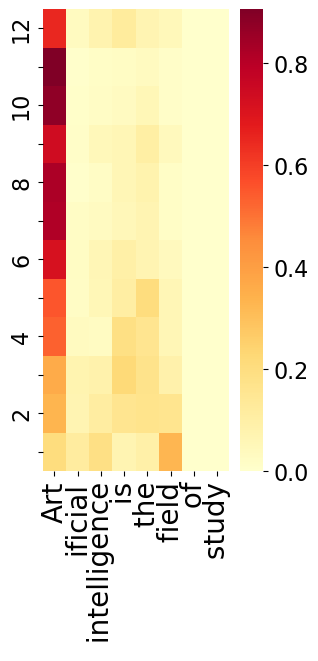

In [ ]:
plt.figure(2,figsize=(3,6))
#soma no eixo das cabeças e tira a média
# passa onde está o mask
# passa t e sentença
# print(attentions_mat.sum(axis=1)/attentions_mat.shape[1])

# basicamente, quanto o s presta atenção aos outros tokens
# é possível ver o automasking

sentenceax = [tokenizer.decode(id) for id in tf_input_ids]
print(sentenceax)
plot_attention_heatmap(attentions_mat.sum(axis=1)/attentions_mat.shape[1], s_position=5, t_positions=(0,1,2,3,4,5,6,7), sentenceax=sentenceax)

#raw attention
plt.savefig('rat_bert_att_{}.png'.format(ex_id), format='png', transparent=True, dpi=360, bbox_inches='tight')

(12, 9, 9)
(117, 117) 12 9
{'0_Art': np.int64(0), '1_ificial': np.int64(1), '2_Ġintelligence': np.int64(2), '3_Ġis': np.int64(3), '4_Ġthe': np.int64(4), '5_Ġfield': np.int64(5), '6_Ġof': np.int64(6), '7_Ġstudy': np.int64(7), '8_Ġthat': np.int64(8), 'L1_0': np.int64(9), 'L1_1': np.int64(10), 'L1_2': np.int64(11), 'L1_3': np.int64(12), 'L1_4': np.int64(13), 'L1_5': np.int64(14), 'L1_6': np.int64(15), 'L1_7': np.int64(16), 'L1_8': np.int64(17), 'L2_0': np.int64(18), 'L2_1': np.int64(19), 'L2_2': np.int64(20), 'L2_3': np.int64(21), 'L2_4': np.int64(22), 'L2_5': np.int64(23), 'L2_6': np.int64(24), 'L2_7': np.int64(25), 'L2_8': np.int64(26), 'L3_0': np.int64(27), 'L3_1': np.int64(28), 'L3_2': np.int64(29), 'L3_3': np.int64(30), 'L3_4': np.int64(31), 'L3_5': np.int64(32), 'L3_6': np.int64(33), 'L3_7': np.int64(34), 'L3_8': np.int64(35), 'L4_0': np.int64(36), 'L4_1': np.int64(37), 'L4_2': np.int64(38), 'L4_3': np.int64(39), 'L4_4': np.int64(40), 'L4_5': np.int64(41), 'L4_6': np.int64(42), 'L4_

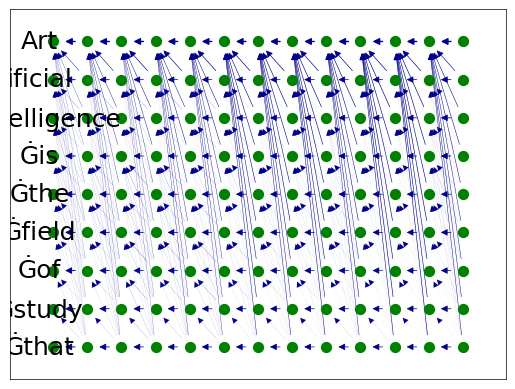

In [117]:
res_att_mat = attentions_mat.sum(axis=1)/attentions_mat.shape[1]
print(res_att_mat.shape)
# print(np.eye(res_att_mat.shape[1]).shape)
# print(np.eye(res_att_mat.shape[1])[None, ...].shape)
res_att_mat = res_att_mat + np.eye(res_att_mat.shape[1])[None,...]

# renormaliza, mesma coisa de dividir por dois
res_att_mat = res_att_mat / res_att_mat.sum(axis=-1)[...,None]
# print((res_att_mat/2) [0])
# print(res_att_mat[0]) 

# [[0, 0, 0, ..., 0]]
# [[W1, 0, 0, ..., 0]]
# [[0, W2, 0, ..., 0]]
# [[0, 0, 0, ..., Wn, 0]]
res_adj_mat, res_labels_to_index = get_adjmat(mat=res_att_mat, input_tokens=tokens)

print(res_labels_to_index)

res_G = draw_attention_graph(res_adj_mat,res_labels_to_index, n_layers=res_att_mat.shape[0], length=res_att_mat.shape[-1])

['0_Art', '1_ificial', '2_Ġintelligence', '3_Ġis', '4_Ġthe', '5_Ġfield', '6_Ġof', '7_Ġstudy', '8_Ġthat']
[]


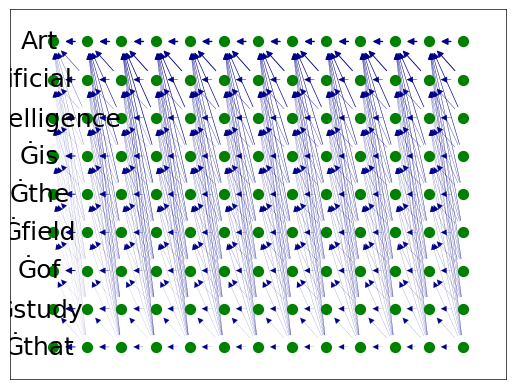

In [118]:
output_nodes = []
input_nodes = []
for key in res_labels_to_index:
    if 'L24' in key:
        # não entendi
        output_nodes.append(key)
    if res_labels_to_index[key] < attentions_mat.shape[-1]:
        input_nodes.append(key)
print(input_nodes)
print(output_nodes)

import importlib
import attention_graph_util as a
importlib.reload(a)

# attention flow
# basta entender agora o algoritmo de max flow
flow_values = a.compute_flows(res_G, res_labels_to_index, input_nodes, length=attentions_mat.shape[-1])
flow_G = draw_attention_graph(flow_values,res_labels_to_index, n_layers=attentions_mat.shape[0], length=attentions_mat.shape[-1])

# dá para perceber também o masking, dado que os tokens só observam o passado, a concentração é maior nos tokens iniciais

(12, 9, 9)


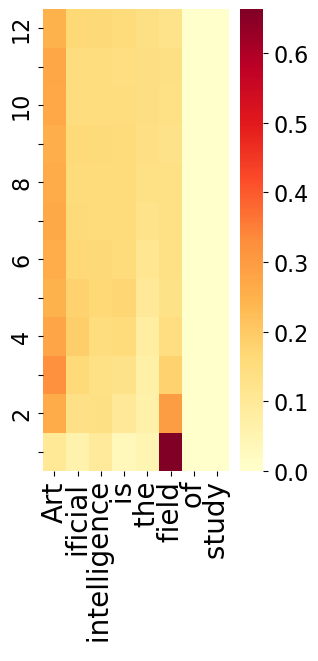

In [ ]:
flow_att_mat = convert_adjmat_tomats(flow_values, n_layers=attentions_mat.shape[0], l=attentions_mat.shape[-1])

# print(flow_att_mat)

plt.figure(3,figsize=(3,6))
plot_attention_heatmap(flow_att_mat, s_position=5, t_positions=(0,1,2,3,4,5,6,7), sentenceax=sentenceax)

# attention flow
plt.savefig('res_fat_bert_att_{}.png'.format(ex_id), format='png', transparent=True,dpi=360, bbox_inches='tight')

(104, 104) 12 8


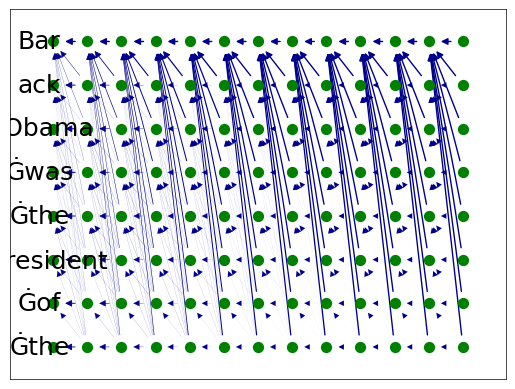

In [106]:
#attention rollout
joint_attentions = compute_joint_attention(res_att_mat, add_residual=False)


joint_att_adjmat, joint_labels_to_index = get_adjmat(mat=joint_attentions, input_tokens=tokens)

G = draw_attention_graph(joint_att_adjmat,joint_labels_to_index, n_layers=joint_attentions.shape[0], length=joint_attentions.shape[-1])

(12, 8, 8)


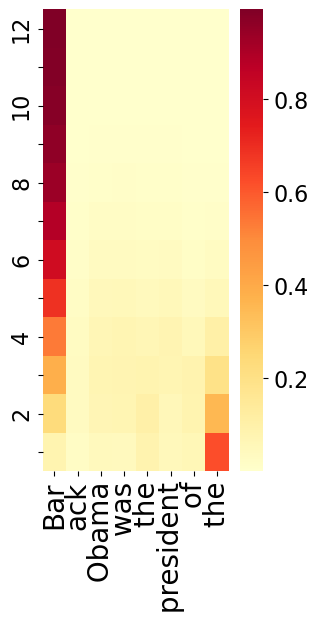

In [ ]:
plt.figure(4,figsize=(3,6))
plot_attention_heatmap(joint_attentions, 7, t_positions=(0,1,2,3,4,5,6,7), sentenceax=sentenceax)
plt.savefig('res_jat_bert_att_{}.png'.format(ex_id), format='png', transparent=True, dpi=360, bbox_inches='tight')